In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import tempfile
import shutil
import matplotlib.pyplot as plt

# fix cuDNN init error
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# find .py modules in subfolders
import my_paths
%load_ext autoreload
%autoreload 2

# project modules
import text_generator as tg
import morse_dataset as md
import training_settings as ts
import loss_func
import model_builder
import keying_stats as ks
import accuracy as ac
import axes

### Create model with weights
The model is defined and trained in model.ipynb. Build a model of the same structure, load the weights.

In [2]:
test_settings = ts.training_settings.copy()

model = model_builder.build_model(
    test_settings['batch_size'], 
    test_settings['spectrogram_width'], 
    test_settings['overlap_margin'], 
    test_settings['spectrogram_height']
)

path = os.path.abspath(os.path.join('model', 'weights.h5'))
model.load_weights(path)

#model.to_json()

### Accuracy Chart

2024-10-27 11:15:28.017184
..........{'keying_style': <KeyingStyle.Paddle: 2>, 'wpm': 24, 'doppler_spread': 0.1, 'snr': 50}
[0.9507945541303682, 0.8225085458848278, 0.47396925227113906, 0.3201773450404242, 0.20191258023667089, 0.0854927921257785, 0.05637448451346846, 0.02455542447677721, 0.020392122614732982, 0.019350893286157342]


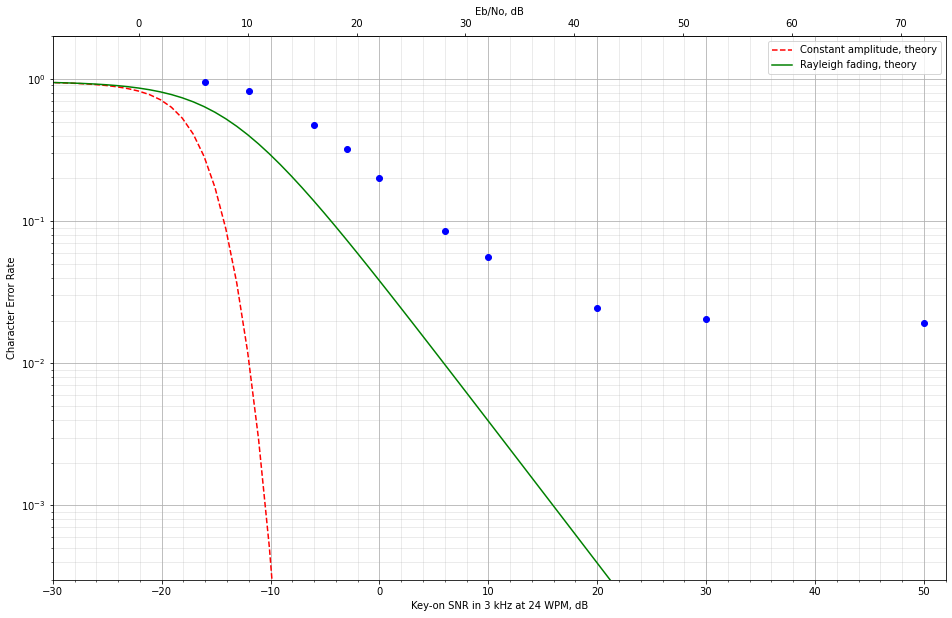

Wall time: 23min 56s


In [11]:
%%time
from datetime import datetime

const_settings = ts.training_settings.copy()

#keyings = [ks.KeyingStyle.HandKey, ks.KeyingStyle.Paddle]
#wpms = [8,12,18,24,32,40,48]
#dopplers = [0.1, 0.3, 1, 3]
#snrs = [-16, -12, -6, -3, 0, 6, 10, 20, 30, 50]

keyings = [ks.KeyingStyle.Paddle]
wpms = [24]
dopplers = [0.1]
snrs = [-16, -12, -6, -3, 0, 6, 10, 20, 30, 50]

for keying in keyings:
    for wpm in wpms:
        for doppler in dopplers:
            print(datetime.now())
            errs = []
            for snr in snrs:
                var_settings = {
                    'keying_style': keying,
                    'wpm': wpm, 
                    'doppler_spread': doppler,
                    'snr': snr, 
                }                     
                all_settings = {**const_settings, **var_settings}
                chart_ds = md.create_morse_dataset(all_settings)
                err = ac.compute_accuracy_cont(chart_ds, model, all_settings,chars_to_use=30000)
                errs.append(err[0])  
                print('.', end='', flush=True)
            print(var_settings)
            print(errs)

ax = axes.plot_axes()
#ax.plot(snrs, e2, 'ro-', label='~wpm ~snr ~dopp, ~offs')  
if len(errs) > 0: ax.plot(snrs, errs, 'bo')  
ax.legend()    
plt.show()    

### Accuracy

In [4]:
%%time
var_settings = {  
    'wpm': 12, 
    'snr': 0, 
    'doppler_spread': 0.1,
    'keying_style': ks.KeyingStyle.Paddle,
    'pitch_error': 0,

    'window_function_length': 300
}

test_settings = {**ts.training_settings, **var_settings}
print(f'Settings: {test_settings}\n')

val_ds = md.create_morse_dataset(test_settings)

# %lprun -f compute_accuracy_cont compute_accuracy_cont(print_messages=False)
acc = ac.compute_accuracy_cont(val_ds, model, test_settings, print_messages=False)
print(f'Accuracy: {acc}\n')

Settings: {'snr': 0, 'wpm': 12, 'doppler_spread': 0.1, 'keying_style': <KeyingStyle.Paddle: 2>, 'pitch_error': 0, 'noise_floor': {'low': -20, 'high': 20}, 'frame_step': 64, 'window_function_length': 300, 'spectrogram_width': 512, 'spectrogram_height': 22, 'overlap_margin': 3, 'continuous': True, 'fft_length': 512, 'batch_size': 4, 'batch_count': 329, 'randomize_every_batches': 5}

Accuracy: (0.16326530612244897, 0.2723735408560311)

Wall time: 8.73 s


### Decode examples

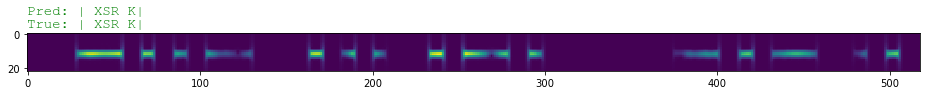

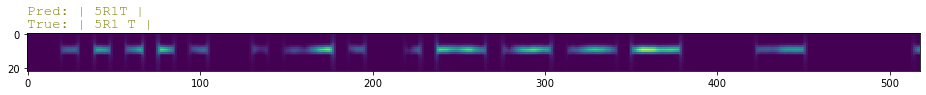

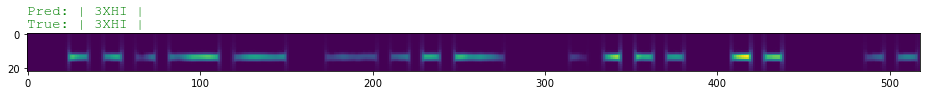

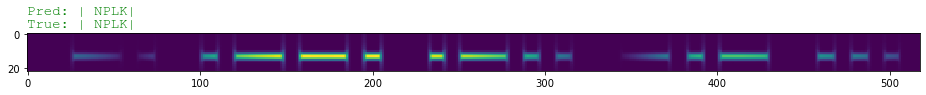

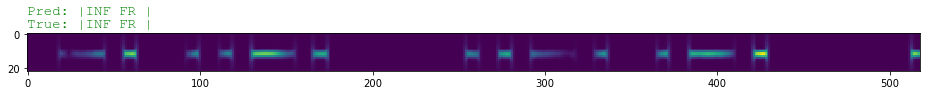

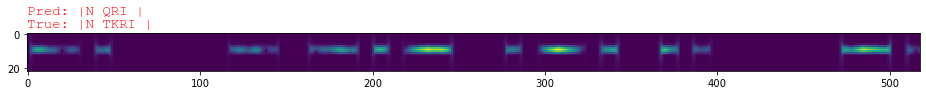

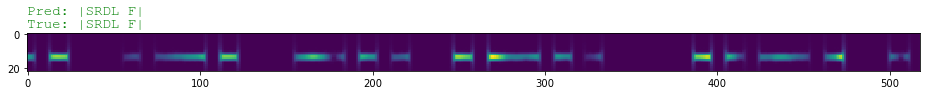

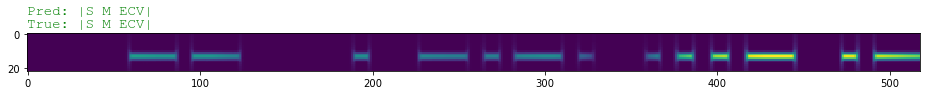

In [14]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)
    results = results[0][0]
    decoded_texts = []
    for res in results:
        res = tf.boolean_mask(res, res >= 0)
        txt = tg.num_to_morse_text(res)
        decoded_texts.append(txt)
    return decoded_texts    


settings = ts.training_settings.copy()
BATCH_SIZE = settings['batch_size']
settings['wpm'] = 12
settings['snr'] = 40
test_ds = md.create_morse_dataset(settings)

model.reset_states()
for batch in test_ds.take(10 // BATCH_SIZE):
    res = model.predict(batch[0])
    decoded = decode_batch_predictions(res)
    for i in range(BATCH_SIZE):
        pred = decoded[i]
        true = tg.num_to_morse_text(batch[1][i])            
        
        if pred == true:
            color = 'green'.strip()
        elif pred.replace(' ', '') == true.replace(' ', ''):
            color = 'olive'
        else:
            color = 'red'
          
        plt.figure(figsize=(16, 2))
        plt.title(f"Pred: |{pred}|\nTrue: |{true}|", 
                  color=color, loc='left', fontdict={'family': 'courier new', 'size': 14})
        plt.imshow(batch[0][i][:,:,0].numpy().T, interpolation='none')
        plt.show()


### Trellis

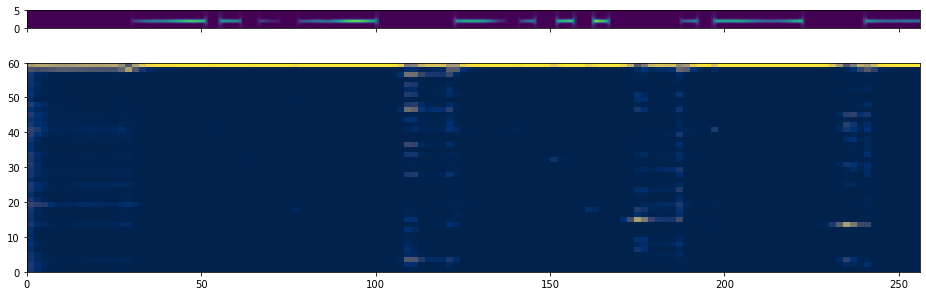

In [12]:
def cross_entropy(p):
    e = 0.0001
    p = e + p * (1-2*e)
    return np.log(p/(1-p))
 
model.reset_states()
sample = iter(test_ds).get_next()
spectra = sample[0][0][:,:,0].numpy().T
trellis = cross_entropy(model.predict(sample[0])[0].T[-1:0:-1])
f=np.linspace(0, 1, len(spectra[0]))
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(16, 5), gridspec_kw={'height_ratios': [1,12]})
ax[0].imshow(spectra, interpolation='none', extent=(0,256,0,5))
ax[1].imshow(trellis, interpolation='none', extent=(0,256,0,60), cmap='cividis')
plt.show()